# instance 1

# baseline model with dropout regularization

In [1]:
import os, sys


import pandas as pd
pd.options.display.max_rows

import numpy as np
from numpy import ones
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from numpy import load

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import fbeta_score


from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import backend
from keras.optimizers import SGD

import cv2

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# load train and test dataset
def load_dataset():
    # load dataset
    data = load('planet_data.npz')
    X, y = data['arr_0'], data['arr_1']
    # separate into train and test datasets
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY


# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)
> loss=0.132, fbeta=0.847
CPU times: user 4d 55min 16s, sys: 2d 2h 20min 48s, total: 6d 3h 16min 5s
Wall time: 9h 13min 16s


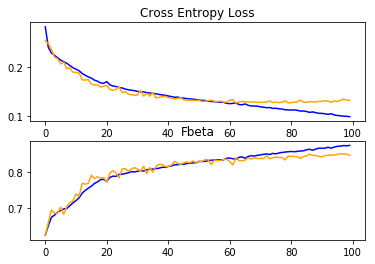

In [6]:
%%time

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY
 
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score
 
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Fbeta')
	plt.plot(history.history['fbeta'], color='blue', label='train')
	plt.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
#	filename = sys.argv[0].split('/')[-1]
#	pyplot.savefig(filename + '_plot.png')
#	pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=100, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()